In [1]:
!pwd

/Users/aaron/Documents/github/apache_beam_examples/notebooks


In [2]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions

import tensorflow as tf
from tensorflow.contrib.learn.python import datasets
tf.enable_eager_execution()

# in-memory data

In [3]:
"""
This module should implement `base_example_gen_executor.BaseExampleGenExecutor`

It will take MNIST data from a given directory and convert it to tf.Example
records using Apache Beam for use by its parent's class

Helper functions code borrowed from and adapted from here in order to read Gzip MNIST files
from an arbitrary location and return them as numpy.ndarray

https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import gzip

import numpy
from six.moves import xrange  # pylint: disable=redefined-builtin

from tensorflow.contrib.learn.python.learn.datasets import base
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import random_seed
from tensorflow.python.platform import gfile
from tensorflow.python.util.deprecation import deprecated

def _read32(bytestream):
  dt = numpy.dtype(numpy.uint32).newbyteorder('>')
  return numpy.frombuffer(bytestream.read(4), dtype=dt)[0]

def extract_images(f):
  """Extract the images into a 4D uint8 numpy array [index, y, x, depth].

  Args:
    f: A file object that can be passed into a gzip reader.

  Returns:
    data: A 4D uint8 numpy array [index, y, x, depth].

  Raises:
    ValueError: If the bytestream does not start with 2051.

  """
  print('Extracting', f.name)
  with gzip.GzipFile(fileobj=f) as bytestream:
    magic = _read32(bytestream)
    if magic != 2051:
      raise ValueError('Invalid magic number %d in MNIST image file: %s' %
                       (magic, f.name))
    num_images = _read32(bytestream)
    rows = _read32(bytestream)
    cols = _read32(bytestream)
    buf = bytestream.read(rows * cols * num_images)
    data = numpy.frombuffer(buf, dtype=numpy.uint8)
    data = data.reshape(num_images, rows, cols, 1)
    return data


def extract_labels(f, one_hot=False, num_classes=10):
  """Extract the labels into a 1D uint8 numpy array [index].

  Args:
    f: A file object that can be passed into a gzip reader.
    one_hot: Does one hot encoding for the result.
    num_classes: Number of classes for the one hot encoding.

  Returns:
    labels: a 1D uint8 numpy array.

  Raises:
    ValueError: If the bystream doesn't start with 2049.
  """
  print('Extracting', f.name)
  with gzip.GzipFile(fileobj=f) as bytestream:
    magic = _read32(bytestream)
    if magic != 2049:
      raise ValueError('Invalid magic number %d in MNIST label file: %s' %
                       (magic, f.name))
    num_items = _read32(bytestream)
    buf = bytestream.read(num_items)
    labels = numpy.frombuffer(buf, dtype=numpy.uint8)
    if one_hot:
      return tf.one_hot(labels, num_classes)
    return labels


def get_images_and_labels(images_path, labels_path):
  """
  Extract gzip images/labels from path
  """
  with gfile.Open(images_path, 'rb') as f:
    images = extract_images(f)

  with gfile.Open(labels_path, 'rb') as f:
    labels = extract_labels(f)

  return images, labels

In [4]:
images_path = '/tmp/data/mnist/train/images.gz'
labels_path = '/tmp/data/mnist/train/labels.gz'
    
train_images, train_labels = get_images_and_labels(images_path, labels_path)

train_images.shape, train_labels.shape

Extracting /tmp/data/mnist/train/images.gz
Extracting /tmp/data/mnist/train/labels.gz


((60000, 28, 28, 1), (60000,))

In [5]:
images_path = '/tmp/data/mnist/val/images.gz'
labels_path = '/tmp/data/mnist/val/labels.gz'
    
val_images, val_labels = get_images_and_labels(images_path, labels_path)

val_images.shape, val_labels.shape

Extracting /tmp/data/mnist/val/images.gz
Extracting /tmp/data/mnist/val/labels.gz


((10000, 28, 28, 1), (10000,))

In [6]:
labels_w_index = [(i,x) for i,x in enumerate(val_labels)]

labels_w_index[:5]

[(0, 7), (1, 2), (2, 1), (3, 0), (4, 4)]

In [7]:
images_w_index = [(i,x) for i,x in enumerate(val_images)]

images_w_index[0][0], images_w_index[0][1].shape

(0, (28, 28, 1))

In [8]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [9]:
images = val_images
N = images.shape[0]
rows = images.shape[1]
cols = images.shape[2]
depth = images.shape[3]

In [10]:
N, rows, cols, depth

(10000, 28, 28, 1)

In [11]:
def group_by_tf_example(key_value):
    _, value = key_value
    image = value['image'][0]
    label = value['label'][0]
    example = tf.train.Example(
          features=tf.train.Features(
              feature={
                  'height': _int64_feature(rows),
                  'width': _int64_feature(cols),
                  'depth': _int64_feature(depth),
                  'label': _int64_feature(int(label)),
                  'image_raw': _bytes_feature(image.tostring())
              })
        )
    return example

with beam.Pipeline(options=PipelineOptions()) as p:
    label_line = p | "CreateLabel" >> beam.Create(labels_w_index[:1])
    image_line = p | "CreateImage" >> beam.Create(images_w_index[:1])
    
    group_by = ({'label': label_line, 'image': image_line}) | beam.CoGroupByKey()
    
    tf_example = group_by | "GroupByToTfExample" >> beam.Map(group_by_tf_example)
    
    serialize = (tf_example | 'SerializeDeterministically' >>
          beam.Map(lambda x: x.SerializeToString(deterministic=True)))
        
    output = serialize | beam.io.WriteToTFRecord('mnist-out-4', file_name_suffix='.gz')

In [12]:
!cat mnist-out-4-00000-of-00001.gz

�      �ff ��x�
�l\|\�)�%B�R�\��\�\l���%�%l\������E��B�ظ&�qM`c6 d���6*������Ǡ`�	��s�G����U�z��_�fA'>gggk�7��p����)����qik��N����v�����͊C���+\���m�%����%)����b>��29��|qH�?�ẄC���?R��p�U��w[��y\q���QNbRj$۰���)�|%s%7f. �J�{  

# read TFRecord

In [21]:
filename = 'mnist-out-4-00000-of-00001.gz'
filenames = [filename]
raw_dataset = tf.data.TFRecordDataset(filenames, compression_type='GZIP')
raw_dataset

<TFRecordDataset shapes: (), types: tf.string>

In [22]:
for raw_record in raw_dataset.take(1):
    print(repr(raw_record))

<tf.Tensor: id=37, shape=(), dtype=string, numpy='\n\xe8\x06\n\x0e\n\x05depth\x12\x05\x1a\x03\n\x01\x01\n\x0f\n\x06height\x12\x05\x1a\x03\n\x01\x1c\n\xa4\x06\n\timage_raw\x12\x96\x06\n\x93\x06\n\x90\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

In [23]:
# Create a description of the features.
# feature=({
#   'height': _int64_feature(rows),
#   'width': _int64_feature(cols),
#   'depth': _int64_feature(depth),
#   'label': _int64_feature(int(label)),
#   'image_raw': _bytes_feature(image.tostring())
# })

feature_description = {
    'height': tf.FixedLenFeature([], tf.int64, default_value=0),
    'width': tf.FixedLenFeature([], tf.int64, default_value=0),
    'depth': tf.FixedLenFeature([], tf.int64, default_value=0),
    'label': tf.FixedLenFeature([], tf.int64, default_value=0),
    'image_raw': tf.FixedLenFeature([], tf.string, default_value=''),
}

def _parse_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.parse_single_example(example_proto, feature_description)

In [24]:
parsed_dataset = raw_dataset.map(_parse_function)
parsed_dataset

<MapDataset shapes: {image_raw: (), depth: (), label: (), width: (), height: ()}, types: {image_raw: tf.string, depth: tf.int64, label: tf.int64, width: tf.int64, height: tf.int64}>

In [25]:
for parsed_record in parsed_dataset.take(1):
    print(repr(parsed_record))

{'image_raw': <tf.Tensor: id=69, shape=(), dtype=string, numpy='\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00T\xb9\x9f\x97<$\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xde\xfe\xfe\xfe\xfe\xf1\

In [26]:
type(parsed_record)

dict

In [27]:
parsed_record.keys()

['image_raw', 'depth', 'label', 'width', 'height']

In [28]:
type(raw_record)

EagerTensor

In [32]:
type(parsed_record['image_raw'])

EagerTensor

In [48]:
import IPython.display as display
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

image_raw = raw_record.numpy()
display.display(display.Image(data=image_raw))

In [49]:
image_ndarray = images_w_index[0][1]

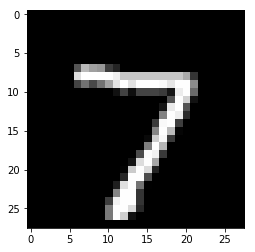

In [54]:
def display_image(img):
    assert isinstance(img, np.ndarray), type(img)

    stacked_img = np.stack((np.squeeze(img),)*3, axis=-1)
    assert stacked_img.shape == (28, 28, 3), stacked_img.shape

    plt.imshow(stacked_img, cmap=plt.get_cmap('gray'))
    
display_image(image_ndarray)

In [67]:
x = parsed_record['image_raw']

print(type(x))            # <type 'EagerTensor'>
print(type(x.numpy()))    # <type 'numpy.ndarray'>
raw_record_ndarray = np.array(x.numpy())
print(type(raw_record_ndarray))

raw_record_ndarray.shape

<type 'EagerTensor'>
<type 'str'>
<type 'numpy.ndarray'>


()

In [68]:
x_np = x.numpy()

In [75]:
import io

rows = 28
cols = 28
num_images = 1
bytestream = io.BytesIO(x_np)
buf = bytestream.read(rows * cols * num_images)
data = numpy.frombuffer(buf, dtype=numpy.uint8)
data = data.reshape(rows, cols, 1)
data.shape

(28, 28, 1)

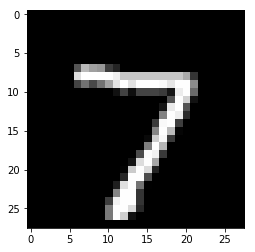

In [76]:
display_image(data)

In [46]:
display.display(display.Image(data=image_ndarray.tobytes()))

# download MNIST data

In [ ]:
datasets.mnist.read_data_sets('/tmp/data/')